# Import packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import optuna
import sqlite3

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Setup DB

In [2]:
connection = sqlite3.connect('/home/ben/dl-final-exam/study.db')

# Setup model tuning pipeline

In [3]:
# Define variables
image_size = (256, 256)
num_classes = 6
num_epochs = 10
batch_size =32

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = "cpu"

In [4]:
# Define the PyTorch model
def create_model(trial):
    # Sample hyperparameters to optimize
    num_filters = trial.suggest_int('num_filters', 16, 128)
    num_neurons = trial.suggest_int('num_neurons', 16, 128)
    num_layers = trial.suggest_int('num_layers', 1, 4)

    final_fmap_size = image_size[0]//2**(num_layers+1)
    
    layers = []
    layers.append(nn.Conv2d(1, num_filters, kernel_size=3, stride=1, padding=1))
    layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2))

    for _ in range(num_layers):
        layers.append(nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2))
    
    layers.append(nn.Flatten())
    layers.append(nn.Linear((final_fmap_size**2)*num_filters, num_neurons))
    layers.append(nn.ReLU())
    layers.append(nn.Linear(num_neurons, num_classes))
    layers.append(nn.Softmax(dim=1))

    model = nn.Sequential(*layers)
    return model

In [5]:
# Define the objective function
def objective(trial):
    # Sample hyperparameters to optimize
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
#     batch_size = trial.suggest_categorical('batch_size', [16, 32])
    
    # Create the model
    model = create_model(trial)
    model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            
            # Forward pass
            scores = model(data)
            loss = criterion(scores, targets)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        torch.cuda.empty_cache()
    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device)
            
            scores = model(data)
            _, predicted = scores.max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = correct / total
    
    return accuracy

In [6]:
# Set up data loaders
train_dir = 'data/train'
val_dir = 'data/val'

# Define transformations for data normalization and grayscale conversion
data_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

# Create datasets for training, validation, and testing
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=data_transforms)

# Create data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

torch.Size([1, 256, 256])


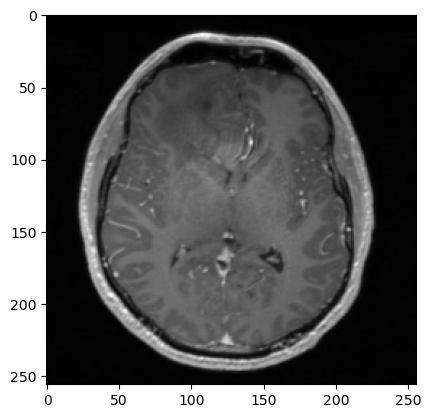

In [7]:
# Load a sample image
sample_image, _ = train_dataset[0]

# Print the shape of the sample image tensor
print(sample_image.shape)

# Visualize the sample image
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.show()

In [8]:
# Set up Optuna study
study = optuna.create_study(direction='maximize', storage="sqlite:///study.db")
study.optimize(objective, n_trials=100)

[I 2023-06-12 08:30:17,937] A new study created in RDB with name: no-name-548ba256-f251-4955-b8d8-6f25507035ec
[I 2023-06-12 08:44:13,015] Trial 0 finished with value: 0.7777777777777778 and parameters: {'learning_rate': 3.933611459401786e-05, 'num_filters': 41, 'num_layers': 3, 'num_neurons': 56}. Best is trial 0 with value: 0.7777777777777778.
[I 2023-06-12 09:09:22,616] Trial 1 finished with value: 0.6388888888888888 and parameters: {'learning_rate': 1.2724538974630215e-05, 'num_filters': 103, 'num_layers': 4, 'num_neurons': 50}. Best is trial 0 with value: 0.7777777777777778.
[I 2023-06-12 09:36:36,723] Trial 2 finished with value: 0.6916666666666667 and parameters: {'learning_rate': 1.3764949641102971e-05, 'num_filters': 110, 'num_layers': 4, 'num_neurons': 72}. Best is trial 0 with value: 0.7777777777777778.
[I 2023-06-12 09:50:01,896] Trial 3 finished with value: 0.6777777777777778 and parameters: {'learning_rate': 2.6316110708110732e-05, 'num_filters': 40, 'num_layers': 4, 'num

[I 2023-06-12 20:32:13,488] Trial 35 finished with value: 0.8361111111111111 and parameters: {'learning_rate': 0.0001455180174082143, 'num_filters': 104, 'num_layers': 1, 'num_neurons': 87}. Best is trial 15 with value: 0.9055555555555556.
[I 2023-06-12 20:50:35,775] Trial 36 finished with value: 0.775 and parameters: {'learning_rate': 9.674628761532541e-05, 'num_filters': 70, 'num_layers': 3, 'num_neurons': 51}. Best is trial 15 with value: 0.9055555555555556.
[I 2023-06-12 21:05:45,624] Trial 37 finished with value: 0.8444444444444444 and parameters: {'learning_rate': 5.2945889695929893e-05, 'num_filters': 60, 'num_layers': 2, 'num_neurons': 38}. Best is trial 15 with value: 0.9055555555555556.
[I 2023-06-12 21:18:53,326] Trial 38 finished with value: 0.875 and parameters: {'learning_rate': 6.715608495543081e-05, 'num_filters': 42, 'num_layers': 1, 'num_neurons': 102}. Best is trial 15 with value: 0.9055555555555556.
[I 2023-06-12 21:40:04,597] Trial 39 finished with value: 0.8166666

[I 2023-06-13 10:28:21,168] Trial 70 finished with value: 0.9 and parameters: {'learning_rate': 0.00010529292882508394, 'num_filters': 109, 'num_layers': 2, 'num_neurons': 119}. Best is trial 50 with value: 0.9222222222222223.
[I 2023-06-13 10:54:58,079] Trial 71 finished with value: 0.9222222222222223 and parameters: {'learning_rate': 0.00013557737863303699, 'num_filters': 113, 'num_layers': 2, 'num_neurons': 110}. Best is trial 50 with value: 0.9222222222222223.
[I 2023-06-13 11:21:02,995] Trial 72 finished with value: 0.9083333333333333 and parameters: {'learning_rate': 8.061747538445869e-05, 'num_filters': 112, 'num_layers': 2, 'num_neurons': 110}. Best is trial 50 with value: 0.9222222222222223.
[I 2023-06-13 11:47:11,028] Trial 73 finished with value: 0.8694444444444445 and parameters: {'learning_rate': 7.311489575124685e-05, 'num_filters': 112, 'num_layers': 2, 'num_neurons': 109}. Best is trial 50 with value: 0.9222222222222223.
[I 2023-06-13 12:14:59,644] Trial 74 finished wit

In [9]:
# Print best hyperparameters and accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

Best Hyperparameters: {'learning_rate': 6.547274145820842e-05, 'num_filters': 120, 'num_layers': 1, 'num_neurons': 113}
Best Accuracy: 0.9333333333333333


In [10]:
torch.cuda.memory_allocated()

17039360